In [1]:
import os
import sys
import json
import spotipy
import webbrowser
import requests
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import base64
from spotipy.oauth2 import SpotifyOAuth

# Create our spotify object with permissions

spotifyObject = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id="a5fbf573349d41f196ffeb3c440dfc3e",
                                                          client_secret="41ead63420ac46a184b37919d26b9532",
                                                          redirect_uri="http://127.0.0.1:9090/",
                                                        

                                                          scope="user-read-private user-read-playback-state user-modify-playback-state user-top-read playlist-modify-public playlist-modify-private"))

# User information
user = spotifyObject.current_user()
userID = user['id']
displayName = user['display_name']
followers = user['followers']['total']
print("Welcome to Spotipy Wrapped, " + displayName + "!")
print("You have " + str(followers) + " followers.")

# Get current device
devices = spotifyObject.devices()
if len(devices['devices']) != 0:
    deviceName = devices['devices'][0]['name']
    print("Currently active on", deviceName)
    deviceID = devices['devices'][0]['id']

    # Current track information
    trackObject = spotifyObject.current_user_playing_track()
    #playbackType = trackObject['is_playing']
    playbackType = devices['devices'][0]['is_active']
    if playbackType is True:
        isAd = trackObject['currently_playing_type']
    else:
        isAd = True
    if playbackType is True and isAd != "ad":
        artist = trackObject['item']['artists'][0]['name']
        track = trackObject['item']['name']
        print("Currently listening to " + artist + " - " + track)

        # Album Art using matplotlib and PIL
        albumArt = trackObject['item']['album']['images'][0]['url']
        pic = base64.b64encode(requests.get(albumArt).content)
        im = Image.open(BytesIO(base64.b64decode(pic)))
        plt.title(track)
        plt.imshow(im)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


# Wrapped
print("Plotting graphs and generating your Spotipy Wrapped playlist from your Spotify listening history.")
print()


def get_track_ids(time_frame):
    track_ids = []
    for song in time_frame['items']:
        track_ids.append(song['id'])
    return track_ids


top_tracks_long = spotifyObject.current_user_top_tracks(limit=50, offset=0, time_range='long_term')
track_id_list = get_track_ids(top_tracks_long)


def get_track_features(track_id):
    meta = spotifyObject.track(track_id)
    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    query = "artist:" + artist
    query_result = spotifyObject.search(q=query, type='artist')
    genres = query_result['artists']['items'][0]['genres']
    if not genres:
        genre = "N/A"
    else:
        genre = genres[0]
    spotify_url = meta['external_urls']['spotify']
    album_cover = meta['album']['images'][0]['url']
    features = spotifyObject.audio_features(track_id)
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    loudness = features[0]['loudness']
    acousticness = features[0]['acousticness']
    instrumentalness = features[0]['instrumentalness']
    valence = features[0]['valence']
    track_info = [name, album, artist, spotify_url, album_cover, track_id, genre, danceability, energy, loudness, acousticness, instrumentalness, valence]
    return track_info


# Loop over track ids
tracks = []
for i in range(len(track_id_list)):
    track = get_track_features(track_id_list[i])
    tracks.append(track)
    # create dataset
    df = pd.DataFrame(tracks, columns=['name', 'album', 'artist', 'spotify_url', 'album_cover', 'track_id', 'genre', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'valence'])


# Plotting Bar Graph for Top Artists
sns.set_theme(style="darkgrid")
artists = []
for i in range(len(tracks)):
    artists.append(tracks[i][2])

# Creating a dictionary to store frequency of Artists
freq = {}
for item in artists:
    if item in freq:
        freq[item] += 1
    else:
        freq[item] = 1


artistDf = pd.DataFrame(freq.items(), columns=['artists', 'songs'])
artistDf = artistDf[artistDf['artists'] != "Various Artists"]  # Filtering out Various Artists
top_artists = sns.barplot(x='artists', y='songs', data=artistDf.sort_values(by=['songs'], ascending=False).head(10))
top_artists.set_title('Top Artists')
sns.set(font_scale=1.2)
top_artists.set_xticklabels(top_artists.get_xticklabels(), rotation=30, fontsize=7)
# Show the plot
plt.tight_layout()
plt.show()

# Plotting Bar Graph for Top Genres
genres = []
for i in range(len(tracks)):
    genres.append(tracks[i][6])

# Creating a dictionary to store frequency of Genres
freq2 = {}
for item in genres:
    if item in freq2:
        freq2[item] += 1
    else:
        freq2[item] = 1


genresDf = pd.DataFrame(freq2.items(), columns=['genres', 'songs'])
genresDf = genresDf[genresDf['genres'] != "N/A"]  # Filtering out empty values of genres
top_genres = sns.barplot(x='genres', y='songs', data=genresDf.sort_values(by=['songs'], ascending=False).head(10))
top_genres.set_title('Top Genres')
sns.set(font_scale=1.2)
top_genres.set_xticklabels(top_genres.get_xticklabels(), rotation=30, fontsize=8)
# Show the plot
plt.tight_layout()
plt.show()

# Audio Features Plots
audioDf = df[['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence']].copy()
audioFeatures = sns.stripplot(data=audioDf, jitter=0.02)
audioFeatures.set_xticklabels(audioFeatures.get_xticklabels(), fontsize=9)
plt.tight_layout()
plt.show()


# Create Spotipy Wrapped Playlist
playlistList = spotifyObject.user_playlists(userID)
playlistLen = playlistList['total']
playlistIDList = []
ctr = playlistLen//50
if ctr < 1:
    playlistList = spotifyObject.user_playlists(userID)
    for i in playlistList['items']:
        playlistIDList.append(i['name'])
else:
    n = 1
    for i in range(ctr+1):
        playlistList = spotifyObject.user_playlists(userID, offset=n - 1)
        for j in playlistList['items']:
            playlistIDList.append(j['name'])
            n = n + 1

if "My Spotipy Wrapped" in playlistIDList:
    pos = playlistIDList.index("My Spotipy Wrapped")
    temp = spotifyObject.user_playlists(userID, limit=1, offset=pos)
    tempID = temp['items'][0]['id']
    spotifyObject.user_playlist_replace_tracks(userID, tempID, track_id_list)
    print("Your Spotipy Wrapped playlist is ready. Head over to Spotify or share your playlist with your friends!")
    print("https://open.spotify.com/playlist/" + tempID)
else:
    playlist = spotifyObject.user_playlist_create(userID, "My Spotipy Wrapped", public=True, collaborative=False,
                                                  description="This is a playlist generated using the Python Spotipy Module.")
    playlistID = playlist['id']
    spotifyObject.user_playlist_replace_tracks(userID, playlistID, track_id_list)
    print("Your Spotipy Wrapped playlist is ready. Head over to Spotify or share your playlist with your friends!")
    print("https://open.spotify.com/playlist/" + playlistID)

ConnectionError: HTTPSConnectionPool(host='accounts.spotify.com', port=443): Max retries exceeded with url: /api/token (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fce601cb280>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
import os
import sys
import json
import spotipy
import webbrowser
import requests
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import base64
from spotipy.oauth2 import SpotifyOAuth

# Create our spotify object with permissions

spotifyObject = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id="a5fbf573349d41f196ffeb3c440dfc3e",
                                                          client_secret="41ead63420ac46a184b37919d26b9532",
                                                          redirect_uri="http://127.0.0.1:9090/",
                                                        

                                                          scope="user-read-private user-read-playback-state user-modify-playback-state user-top-read playlist-modify-public playlist-modify-private"))

# User information
user = spotifyObject.current_user()
userID = user['id']
displayName = user['display_name']
followers = user['followers']['total']
print("Welcome to Spotipy Wrapped, " + displayName + "!")
print("You have " + str(followers) + " followers.")

# Get current device
devices = spotifyObject.devices()
if len(devices['devices']) != 0:
    deviceName = devices['devices'][0]['name']
    print("Currently active on", deviceName)
    deviceID = devices['devices'][0]['id']

    # Current track information
    trackObject = spotifyObject.current_user_playing_track()
    #playbackType = trackObject['is_playing']
    playbackType = devices['devices'][0]['is_active']
    if playbackType is True:
        isAd = trackObject['currently_playing_type']
    else:
        isAd = True
    if playbackType is True and isAd != "ad":
        artist = trackObject['item']['artists'][0]['name']
        track = trackObject['item']['name']
        print("Currently listening to " + artist + " - " + track)

        # Album Art using matplotlib and PIL
        albumArt = trackObject['item']['album']['images'][0]['url']
        pic = base64.b64encode(requests.get(albumArt).content)
        im = Image.open(BytesIO(base64.b64decode(pic)))
        plt.title(track)
        plt.imshow(im)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


# Wrapped
print("Plotting graphs and generating your Spotipy Wrapped playlist from your Spotify listening history.")
print()


def get_track_ids(time_frame):
    track_ids = []
    for song in time_frame['items']:
        track_ids.append(song['id'])
    return track_ids


top_tracks_long = spotifyObject.current_user_top_tracks(limit=50, offset=0, time_range='long_term')
track_id_list = get_track_ids(top_tracks_long)


def get_track_features(track_id):
    meta = spotifyObject.track(track_id)
    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    query = "artist:" + artist
    query_result = spotifyObject.search(q=query, type='artist')
    genres = query_result['artists']['items'][0]['genres']
    if not genres:
        genre = "N/A"
    else:
        genre = genres[0]
    spotify_url = meta['external_urls']['spotify']
    album_cover = meta['album']['images'][0]['url']
    features = spotifyObject.audio_features(track_id)
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    loudness = features[0]['loudness']
    acousticness = features[0]['acousticness']
    instrumentalness = features[0]['instrumentalness']
    valence = features[0]['valence']
    track_info = [name, album, artist, spotify_url, album_cover, track_id, genre, danceability, energy, loudness, acousticness, instrumentalness, valence]
    return track_info


# Loop over track ids
tracks = []
for i in range(len(track_id_list)):
    track = get_track_features(track_id_list[i])
    tracks.append(track)
    # create dataset
    df = pd.DataFrame(tracks, columns=['name', 'album', 'artist', 'spotify_url', 'album_cover', 'track_id', 'genre', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'valence'])


# Plotting Bar Graph for Top Artists
sns.set_theme(style="darkgrid")
artists = []
for i in range(len(tracks)):
    artists.append(tracks[i][2])

# Creating a dictionary to store frequency of Artists
freq = {}
for item in artists:
    if item in freq:
        freq[item] += 1
    else:
        freq[item] = 1


artistDf = pd.DataFrame(freq.items(), columns=['artists', 'songs'])
artistDf = artistDf[artistDf['artists'] != "Various Artists"]  # Filtering out Various Artists
top_artists = sns.barplot(x='artists', y='songs', data=artistDf.sort_values(by=['songs'], ascending=False).head(10))
top_artists.set_title('Top Artists')
sns.set(font_scale=1.2)
top_artists.set_xticklabels(top_artists.get_xticklabels(), rotation=30, fontsize=7)
# Show the plot
plt.tight_layout()
plt.show()

# Plotting Bar Graph for Top Genres
genres = []
for i in range(len(tracks)):
    genres.append(tracks[i][6])

# Creating a dictionary to store frequency of Genres
freq2 = {}
for item in genres:
    if item in freq2:
        freq2[item] += 1
    else:
        freq2[item] = 1


genresDf = pd.DataFrame(freq2.items(), columns=['genres', 'songs'])
genresDf = genresDf[genresDf['genres'] != "N/A"]  # Filtering out empty values of genres
top_genres = sns.barplot(x='genres', y='songs', data=genresDf.sort_values(by=['songs'], ascending=False).head(10))
top_genres.set_title('Top Genres')
sns.set(font_scale=1.2)
top_genres.set_xticklabels(top_genres.get_xticklabels(), rotation=30, fontsize=8)
# Show the plot
plt.tight_layout()
plt.show()

# Audio Features Plots
audioDf = df[['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence']].copy()
audioFeatures = sns.stripplot(data=audioDf, jitter=0.02)
audioFeatures.set_xticklabels(audioFeatures.get_xticklabels(), fontsize=9)
plt.tight_layout()
plt.show()


# Create Spotipy Wrapped Playlist
playlistList = spotifyObject.user_playlists(userID)
playlistLen = playlistList['total']
playlistIDList = []
ctr = playlistLen//50
if ctr < 1:
    playlistList = spotifyObject.user_playlists(userID)
    for i in playlistList['items']:
        playlistIDList.append(i['name'])
else:
    n = 1
    for i in range(ctr+1):
        playlistList = spotifyObject.user_playlists(userID, offset=n - 1)
        for j in playlistList['items']:
            playlistIDList.append(j['name'])
            n = n + 1

if "My Spotipy Wrapped" in playlistIDList:
    pos = playlistIDList.index("My Spotipy Wrapped")
    temp = spotifyObject.user_playlists(userID, limit=1, offset=pos)
    tempID = temp['items'][0]['id']
    spotifyObject.user_playlist_replace_tracks(userID, tempID, track_id_list)
    print("Your Spotipy Wrapped playlist is ready. Head over to Spotify or share your playlist with your friends!")
    print("https://open.spotify.com/playlist/" + tempID)
else:
    playlist = spotifyObject.user_playlist_create(userID, "My Spotipy Wrapped", public=True, collaborative=False,
                                                  description="This is a playlist generated using the Python Spotipy Module.")
    playlistID = playlist['id']
    spotifyObject.user_playlist_replace_tracks(userID, playlistID, track_id_list)
    print("Your Spotipy Wrapped playlist is ready. Head over to Spotify or share your playlist with your friends!")
    print("https://open.spotify.com/playlist/" + playlistID)

Welcome to Spotipy Wrapped, Bhavay!
You have 9 followers.
Currently active on Bhavay’s MacBook Air
Plotting graphs and generating your Spotipy Wrapped playlist from your Spotify listening history.



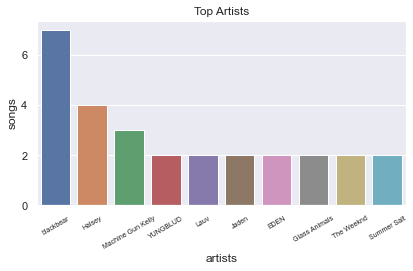

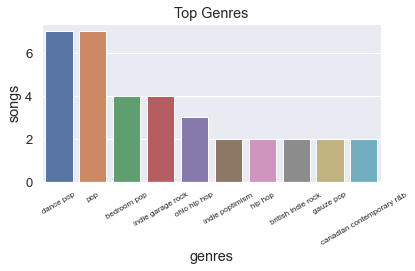

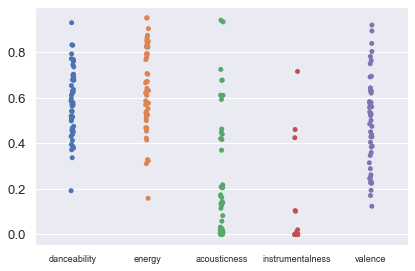

Your Spotipy Wrapped playlist is ready. Head over to Spotify or share your playlist with your friends!
https://open.spotify.com/playlist/3dhjHR4jsh693xtT082BFb


In [2]:
import os
import sys
import json
import spotipy
import webbrowser
import requests
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import base64
from spotipy.oauth2 import SpotifyOAuth

# Create our spotify object with permissions

spotifyObject = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id="a5fbf573349d41f196ffeb3c440dfc3e",
                                                          client_secret="41ead63420ac46a184b37919d26b9532",
                                                          redirect_uri="http://127.0.0.1:9090/",
                                                        

                                                          scope="user-read-private user-read-playback-state user-modify-playback-state user-top-read playlist-modify-public playlist-modify-private"))

# User information
user = spotifyObject.current_user()
userID = user['id']
displayName = user['display_name']
followers = user['followers']['total']
print("Welcome to Spotipy Wrapped, " + displayName + "!")
print("You have " + str(followers) + " followers.")

# Get current device
devices = spotifyObject.devices()
if len(devices['devices']) != 0:
    deviceName = devices['devices'][0]['name']
    print("Currently active on", deviceName)
    deviceID = devices['devices'][0]['id']

    # Current track information
    trackObject = spotifyObject.current_user_playing_track()
    #playbackType = trackObject['is_playing']
    playbackType = devices['devices'][0]['is_active']
    if playbackType is True:
        isAd = trackObject['currently_playing_type']
    else:
        isAd = True
    if playbackType is True and isAd != "ad":
        artist = trackObject['item']['artists'][0]['name']
        track = trackObject['item']['name']
        print("Currently listening to " + artist + " - " + track)

        # Album Art using matplotlib and PIL
        albumArt = trackObject['item']['album']['images'][0]['url']
        pic = base64.b64encode(requests.get(albumArt).content)
        im = Image.open(BytesIO(base64.b64decode(pic)))
        plt.title(track)
        plt.imshow(im)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


# Wrapped
print("Plotting graphs and generating your Spotipy Wrapped playlist from your Spotify listening history.")
print()


def get_track_ids(time_frame):
    track_ids = []
    for song in time_frame['items']:
        track_ids.append(song['id'])
    return track_ids


top_tracks_long = spotifyObject.current_user_top_tracks(limit=50, offset=0, time_range='long_term')
track_id_list = get_track_ids(top_tracks_long)


def get_track_features(track_id):
    meta = spotifyObject.track(track_id)
    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    query = "artist:" + artist
    query_result = spotifyObject.search(q=query, type='artist')
    genres = query_result['artists']['items'][0]['genres']
    if not genres:
        genre = "N/A"
    else:
        genre = genres[0]
    spotify_url = meta['external_urls']['spotify']
    album_cover = meta['album']['images'][0]['url']
    features = spotifyObject.audio_features(track_id)
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    loudness = features[0]['loudness']
    acousticness = features[0]['acousticness']
    instrumentalness = features[0]['instrumentalness']
    valence = features[0]['valence']
    track_info = [name, album, artist, spotify_url, album_cover, track_id, genre, danceability, energy, loudness, acousticness, instrumentalness, valence]
    return track_info


# Loop over track ids
tracks = []
for i in range(len(track_id_list)):
    track = get_track_features(track_id_list[i])
    tracks.append(track)
    # create dataset
    df = pd.DataFrame(tracks, columns=['name', 'album', 'artist', 'spotify_url', 'album_cover', 'track_id', 'genre', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'valence'])


# Plotting Bar Graph for Top Artists
sns.set_theme(style="darkgrid")
artists = []
for i in range(len(tracks)):
    artists.append(tracks[i][2])

# Creating a dictionary to store frequency of Artists
freq = {}
for item in artists:
    if item in freq:
        freq[item] += 1
    else:
        freq[item] = 1


artistDf = pd.DataFrame(freq.items(), columns=['artists', 'songs'])
artistDf = artistDf[artistDf['artists'] != "Various Artists"]  # Filtering out Various Artists
top_artists = sns.barplot(x='artists', y='songs', data=artistDf.sort_values(by=['songs'], ascending=False).head(10))
top_artists.set_title('Top Artists')
sns.set(font_scale=1.2)
top_artists.set_xticklabels(top_artists.get_xticklabels(), rotation=30, fontsize=7)
# Show the plot
plt.tight_layout()
plt.show()

# Plotting Bar Graph for Top Genres
genres = []
for i in range(len(tracks)):
    genres.append(tracks[i][6])

# Creating a dictionary to store frequency of Genres
freq2 = {}
for item in genres:
    if item in freq2:
        freq2[item] += 1
    else:
        freq2[item] = 1


genresDf = pd.DataFrame(freq2.items(), columns=['genres', 'songs'])
genresDf = genresDf[genresDf['genres'] != "N/A"]  # Filtering out empty values of genres
top_genres = sns.barplot(x='genres', y='songs', data=genresDf.sort_values(by=['songs'], ascending=False).head(10))
top_genres.set_title('Top Genres')
sns.set(font_scale=1.2)
top_genres.set_xticklabels(top_genres.get_xticklabels(), rotation=30, fontsize=8)
# Show the plot
plt.tight_layout()
plt.show()

# Audio Features Plots
audioDf = df[['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence']].copy()
audioFeatures = sns.stripplot(data=audioDf, jitter=0.02)
audioFeatures.set_xticklabels(audioFeatures.get_xticklabels(), fontsize=9)
plt.tight_layout()
plt.show()


# Create Spotipy Wrapped Playlist
playlistList = spotifyObject.user_playlists(userID)
playlistLen = playlistList['total']
playlistIDList = []
ctr = playlistLen//50
if ctr < 1:
    playlistList = spotifyObject.user_playlists(userID)
    for i in playlistList['items']:
        playlistIDList.append(i['name'])
else:
    n = 1
    for i in range(ctr+1):
        playlistList = spotifyObject.user_playlists(userID, offset=n - 1)
        for j in playlistList['items']:
            playlistIDList.append(j['name'])
            n = n + 1

if "My Spotipy Wrapped" in playlistIDList:
    pos = playlistIDList.index("My Spotipy Wrapped")
    temp = spotifyObject.user_playlists(userID, limit=1, offset=pos)
    tempID = temp['items'][0]['id']
    spotifyObject.user_playlist_replace_tracks(userID, tempID, track_id_list)
    print("Your Spotipy Wrapped playlist is ready. Head over to Spotify or share your playlist with your friends!")
    print("https://open.spotify.com/playlist/" + tempID)
else:
    playlist = spotifyObject.user_playlist_create(userID, "My Spotipy Wrapped", public=True, collaborative=False,
                                                  description="This is a playlist generated using the Python Spotipy Module.")
    playlistID = playlist['id']
    spotifyObject.user_playlist_replace_tracks(userID, playlistID, track_id_list)
    print("Your Spotipy Wrapped playlist is ready. Head over to Spotify or share your playlist with your friends!")
    print("https://open.spotify.com/playlist/" + playlistID)